In [45]:
import pickle
import pandas as pd
import sentencepiece as spm
import numpy as np
from utils import *

COVERAGE = 0.98
DATA_FOLDER = FILE_PATH(PREPROCESSED)
MERGED_TXT_name = "merged_{streamer}.txt"
streamer = 'zilioner'
model = 'bpe'
model = 'char'
model = 'word'
model = 'unigram'

size = 4000
modelFilename = f'sp_{streamer}_{model}_{size}_0.98.model'

# 클러스터 만들기

먼저 클러스터를 형성하기 위해서 2000개로 형성된 sentencepiece 토크나이저를 이용해 단어를 임베딩 할 예정입니다.

sentencepiece로 인코딩하면 벡터 형태가 아닌 비연속적인(42, 43 --> 둘의 차이는 없음, 단순히 index를 의미함) 값이 나오는데요

예) 안녕하세요 저는 시청자입니다 --> [42, 33, 2334, 201, 400, 981, 1123, 42]

이를 2000개의 numpy array를 만들어 예를 들어 42가 나오면

```python
import sentencepiece as spm
import numpy as np

sp = spm.SentencePieceProcessor()
sp.Load('sentence_piece.model')

encoded = sp.EncodeAsIds("안녕하세요 저는 시청자입니다")

arr = np.zeros(2000)

for index in encoded:
    arr[index] += 1

arr # [0, 0, ... , 2, 0,0, ... , 1, 0,0]
```

위와 같은 방식으로 벡터 형태로 만듭니다.

차원이 너무 많으면 성능이 떨어질 수 있어, PCA를 이용한 주성분 추출(차원 숙소)을 진행

In [47]:
# 클러스터링 진행할 임의의 파일 불러옴
forSample = "1316386840.csv"
df = pd.read_csv(FILE_PATH(PREPROCESSED, streamer, 'csv', forSample))

# 전처리 되고 혹시나 남아있는 비어있는 문자열 제거
df['preprocessed'] = df['preprocessed'].apply(lambda x : x.strip('"'))
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["preprocessed"], inplace=True)

df

,real time,uptime,upsecond,nickname,chat,preprocessed,morphs_Mecab,morphs_Mecab_noun,morphs_Okt,morphs_Okt_noun
0,2022-06-03 13:00:45,0:00:04,4,kclue,"""와따""",와따,['와따'],[],"['와', '따']",[]
1,2022-06-03 13:00:45,0:00:04,4,아레오레,"""광고야 가라~""",광고야 가라,"['광고', '야', '가', '라']",['광고'],"['광고', '야', '가라']","['광고', '가라']"
2,2022-06-03 13:00:47,0:00:06,6,차돌쫄면을출시한철면수심,"""이걸1시에킨다고?""",이걸1시에킨다고?,"['이걸', '1', '시', '에', '킨다', '고', '?']","['이걸', '시', '킨다']","['이', '걸', '1시', '에킨다고', '?']",['걸']
3,2022-06-03 13:00:47,0:00:06,6,베개나라왕자님,"""침하""",침하,"['침', '하']",['침'],['침하'],['침하']
4,2022-06-03 13:00:48,0:00:08,8,문상비,"""시간딱딱맨""",시간딱딱맨,"['시간', '딱딱', '맨']",['시간'],"['시간', '딱', '딱', '맨']","['시간', '맨']"
...,...,...,...,...,...,...,...,...,...,...
65506,2022-06-03 20:08:00,7:07:19,25639,무패의사나이,"""전무의 방종 ...""",전무의 방종,"['전무', '의', '방종']","['전무', '방종']","['전무', '의', '방종']","['전무', '방종']"
65507,2022-06-03 20:08:00,7:07:19,25639,산하랑,"""그립습니다""",그립습니다,"['그립', '습니다']",[],['그립습니다'],[]
65508,2022-06-03 20:08:00,7:07:19,25639,파치리쓰,"""침풍바""",침풍바,"['침', '풍', '바']","['침', '바']","['침', '풍', '바']","['침', '바']"
65509,2022-06-03 20:08:00,7:07:20,25640,kilkea,"""다시 돌아와~~""",다시 돌아와,"['다시', '돌아와']",[],"['다시', '돌아와']",['다시']


사전에 스트리머 '침착맨'의 모든 채팅을 모은 텍스트 파일로 학습한 토크나이저를 이용해 인코딩합니다.

그리고 인코딩 크기와 같은 np.array를 만들어 인코딩된 텍스트(정수)를 인덱스로 삼아 np.array[i] += 1.0 을 사용합니다.

카운트 기반의 단어 표현을 사용합니다.

In [61]:
# 인코딩할 파일 로드
modelFilepath = str(FILE_PATH(PREPROCESSED, streamer, model, modelFilename))
sp = spm.SentencePieceProcessor()
sp.Load(modelFilepath)

items = []
nparray = np.array([])

for i, chat in enumerate(df[PREPROCESSED].to_list(), start =1):
    items.append(sp.EncodeAsIds(chat.strip('"')))
print()
tttt=  []
for i, ii in enumerate(items, start=1):
    target = np.zeros(size)
    for index in ii:
        target[index] += 1.0
    tttt.append(target)

nparray = np.array(tttt)

nparray.shape, nparray.size

((65381, 4000), 261524000)

2000개의 차원을 100개의 차원으로 축소합니다.

더 작은 숫자로 축소할 경우 유사하지 않은 문장들이(사람의 관점에서 볼 떄) 단 몇글자만 같을 경우 같은 클러스터로 포함된는 일이 일어나

100개의 차원이 적당하다고 판단되어 진행했습니다.

KernalPCA의 경우 비선형적으로 주성분은 분류해 클러스터링 하기 좋지만,

차원이 2000개에다가 시스템에 요구하는 용량이 50GiB(이번 파일의 경우)이나 되어 진행하지 못했습니다. 

In [62]:
from sklearn.decomposition import PCA, KernelPCA
model_pca = PCA(n_components=100)
model_pca.fit(nparray)

# transformer = KernelPCA(n_components=10, kernel='linear')
# transformer.fit(nparray)
print(model_pca.explained_variance_ratio_)

[0.08235872 0.03065997 0.02775694 0.01722992 0.01145845 0.01124306
 0.00943309 0.00790891 0.00694647 0.00685372 0.00560061 0.00558456
 0.00538871 0.00524879 0.00516381 0.00496544 0.00487037 0.00480082
 0.00468556 0.00459725 0.00455546 0.00442197 0.00432748 0.00426507
 0.00419707 0.00395372 0.00381498 0.00369573 0.00359722 0.00355573
 0.00349623 0.00340301 0.00332294 0.00327247 0.0031121  0.00303448
 0.00298873 0.00297298 0.00289649 0.00288799 0.00280702 0.00278263
 0.00272904 0.00272148 0.0026797  0.00266062 0.00253444 0.00248252
 0.00246684 0.00244601 0.00237105 0.0023657  0.00233913 0.00226379
 0.00224622 0.00217871 0.00213082 0.00210479 0.00207232 0.00197354
 0.00196656 0.00195638 0.00194228 0.00192835 0.00190765 0.0018773
 0.00183608 0.00180807 0.0017919  0.00176711 0.00175675 0.00173106
 0.00171241 0.00169282 0.0016784  0.00167517 0.00166835 0.00165902
 0.00164674 0.00162979 0.00160685 0.00158701 0.00158259 0.00155204
 0.00153277 0.00152474 0.00152225 0.00151599 0.0014884  0.00148

PCA를 진행후 K-means 엘보우 메서드를 시각화한 것입니다.

이 중에서 저희는 7을 적당한 숫자로 선정했습니다.

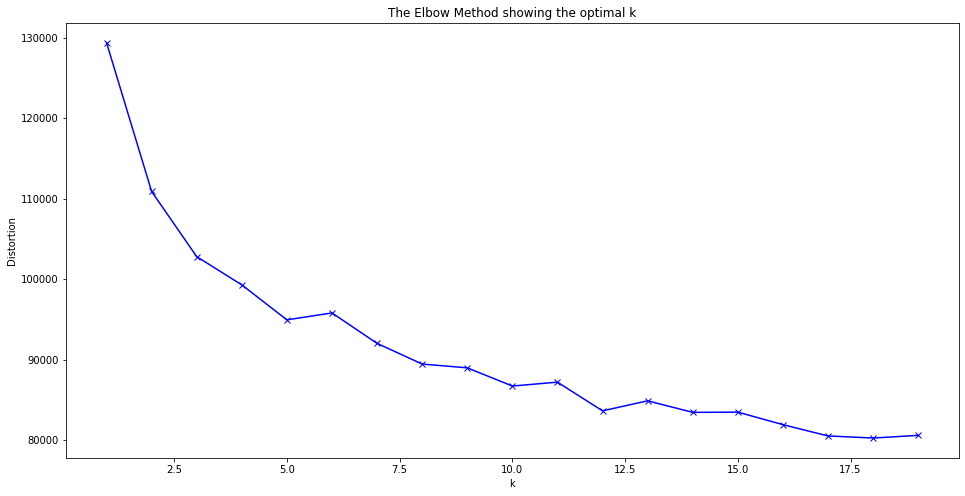

In [63]:
data = model_pca.fit_transform(nparray)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [64]:
Kn = 12
label  =KMeans(Kn).fit_predict(data)
import collections
collections.Counter(label)

Counter({2: 31897,
         1: 2738,
         5: 4344,
         4: 7476,
         11: 3207,
         10: 1836,
         9: 1481,
         6: 2140,
         7: 9421,
         8: 564,
         3: 57,
         0: 220})

In [80]:
df

,real time,uptime,upsecond,nickname,chat,preprocessed,morphs_Mecab,morphs_Mecab_noun,morphs_Okt,morphs_Okt_noun,cluster,label
0,2022-06-03 13:00:45,0:00:04,4,kclue,"""와따""",와따,['와따'],[],"['와', '따']",[],2,0
1,2022-06-03 13:00:45,0:00:04,4,아레오레,"""광고야 가라~""",광고야 가라,"['광고', '야', '가', '라']",['광고'],"['광고', '야', '가라']","['광고', '가라']",2,0
2,2022-06-03 13:00:47,0:00:06,6,차돌쫄면을출시한철면수심,"""이걸1시에킨다고?""",이걸1시에킨다고?,"['이걸', '1', '시', '에', '킨다', '고', '?']","['이걸', '시', '킨다']","['이', '걸', '1시', '에킨다고', '?']",['걸'],1,0
3,2022-06-03 13:00:47,0:00:06,6,베개나라왕자님,"""침하""",침하,"['침', '하']",['침'],['침하'],['침하'],2,0
4,2022-06-03 13:00:48,0:00:08,8,문상비,"""시간딱딱맨""",시간딱딱맨,"['시간', '딱딱', '맨']",['시간'],"['시간', '딱', '딱', '맨']","['시간', '맨']",2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65506,2022-06-03 20:08:00,7:07:19,25639,무패의사나이,"""전무의 방종 ...""",전무의 방종,"['전무', '의', '방종']","['전무', '방종']","['전무', '의', '방종']","['전무', '방종']",2,0
65507,2022-06-03 20:08:00,7:07:19,25639,산하랑,"""그립습니다""",그립습니다,"['그립', '습니다']",[],['그립습니다'],[],2,0
65508,2022-06-03 20:08:00,7:07:19,25639,파치리쓰,"""침풍바""",침풍바,"['침', '풍', '바']","['침', '바']","['침', '풍', '바']","['침', '바']",2,0
65509,2022-06-03 20:08:00,7:07:20,25640,kilkea,"""다시 돌아와~~""",다시 돌아와,"['다시', '돌아와']",[],"['다시', '돌아와']",['다시'],2,0


In [65]:
df['cluster'] = label

In [66]:
for i in range(0, Kn):
    print(f"=========== cluster number {i} =============")
    for u , x in enumerate(df[df['cluster'] == i]['preprocessed']):
        print(x.strip('"'))
        if u >300:
            break

=========== cluster number 0 =============
키타나이
키타나이
키타나이
키타나이 침착맨
키타나이 치무차쿠맨
키타나이
키타나이
키타나이
키타나이
키타나이
침착맨 키타나이
키타나이
키타나이
키타나이
키타나이
키타나이
키타나이
키타나이
1타 강사 침착맨 1타 강사 침착맨
1타 강사 침착맨 침착맨을 노량진으로 1타 강사 침착맨 침착맨을 노량진으로
개방장 키타나이
태오야 시청자는 오후 3시야
오이도는 갈아타야지
오 전무님 오셨네ㅋㅋ
오타반점
맞네 망자도 길 알려줘야 오네
오 김풍형님 오셨네
공산당 할꺼야 안할꺼야
아야야 아야
오박사님 모셔와야
오타쿠마네 저건
쿠쿠하세요 쿠쿠
오는 무슨 소야
와 오 와 오
카타쿠리 씹는맛 날듯
카타쿠리 떡볶이 ㅋㅋ
오 오옷
그래야도리야마센세지
봤구나마타타
봤구나마타타
키타나이
키타나이
오코노미야키
타쿠야
키무라 타쿠야
키무라 타쿠야
키무라 타쿠야
김타쿠
타쿠야
키무라 타쿠야 ㄷㄷ
김타쿠야
키무라오코노미야키
키무타쿠
키무라는 오타쿠야
기무타쿠
키무라 오타쿠야
키무라 타꼬야
키무라 오타쿠야
오타쿠야?
기무라 오타쿠야
기무라 오타쿠야 ㅋㅋ
오타쿠 가게?
키무라 오타구야
키무라 오타쿠야
오타쿠야
키무라 오타쿠야
기무라 오타쿠야
기무라 오타쿠야
키무라 오타쿠야랰ㅋㅋ
키무라 오타쿠야?
키무라 오타쿠야
키모 오타쿠
오타쿠라서 탈락
키무라 오타쿠 아니야
오타쿠야 십타쿠야
키무타쿠
키모 오타쿠 ㅋㅋ
ㅋㅣ무라 오타쿠야
오레와 키무라 오타쿠야데스
오타쿠만 10명 있는거 아님?
키무라 오타쿠야
풍군 키타나이
뭐야 오타쿠래
오타쿠 오피셜 헤에?
사실 거기 전무님 빼고 다 오타큐였던거
키무라 타쿠야 팬이었나보네
다 오타쿠라서 앙웃김ㅋㅋ
다 오타쿠라 면역 ㅋㅋ
키무라 오타 쿠야
타쿠야를 건들이다니
오타쿠 어원도 집이라서 ㅋㅋ
오타쿠야 ㅋㅋ
오타꾸야
오타쿠야ㅋㅋ
오타쿠야 ㄱㄱ
오타쿠야
오타쿠야 당첨
오타쿠야
오타쿠야 ㄱㄱ
오타쿠얔ㅋㅋ
오타쿠야로 해야지 이건 ㅋㅋ
오타쿠야
이제 그냥 오타쿠야
카무타쿠
오타쿠야 ㅋㅋㄱㅋㅋ
오타쿠상ㅋㅋ
오

위에 나온 결과를 보아 클러스터 8, 10 이 그나마 무의미한 채팅과 거리가 멀다고 판단하여
8, 10은 찾고자하는 라벨로 1을
나머지는 0으로 라벨을 바꿨습니다.

In [ ]:
df['label'] = df['cluster'].apply(lambda x : 1 if x in [8, 10] else 0)

훈련용 리뷰의 개수 : 52304
테스트용 리뷰의 개수 : 13077
   label  count
0      0  50394
1      1   1910


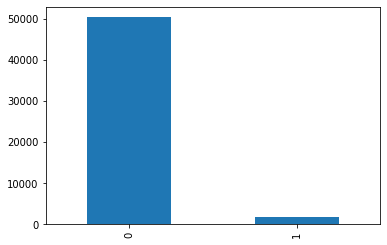

In [79]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.20, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [125]:
train_data

,real time,uptime,upsecond,nickname,chat,preprocessed,morphs_Mecab,morphs_Mecab_noun,morphs_Okt,morphs_Okt_noun,cluster,label,X_train
64221,2022-06-03 20:00:06,6:59:26,25166,로또1등맨,"""강화하고 퍼트렸지 ㅋㅋㅋ""",강화하고 퍼트렸지 ㅋㅋ,"['강화', '하', '고', '퍼트', '렸', '지', 'ㅋㅋ']","['강화', '퍼트', '렸']","['강화하고', '퍼트렸', '지', 'ㅋㅋ']",['퍼트렸'],7,0,"[288, 133, 308, 2218, 54, 1063, 8, 4]"
39741,2022-06-03 17:01:24,4:00:43,14443,올리브그린_,"""텐텐 맛있지""",텐텐 맛있지,"['텐', '텐', '맛있', '지']","['텐', '텐']","['텐텐', '맛있지']",['텐텐'],4,0,"[3, 813, 813, 780, 8]"
28706,2022-06-03 15:53:24,2:52:44,10364,캘리포니아_떡볶이,"""돼지가 농경민족의 상징 양이 유목민족의 상징""",돼지가 농경민족의 상징 양이 유목민족의 상징,"['돼지', '가', '농경', '민족', '의', '상징', '양', '이', '...","['돼지', '농경', '민족', '상징', '양', '유목', '민족', '상징']","['돼지', '가', '농경', '민족', '의', '상징', '양', '이', '...","['돼지', '농경', '민족', '상징', '양', '유목민족', '상징']",6,0,"[1456, 7, 3, 0, 381, 442, 513, 30, 392, 792, 4..."
40137,2022-06-03 17:04:52,4:04:12,14652,pik1002,"""오은영 박사님이 항상 말하는게 육아의 최종 목표는 자녀의 독립과 자립이라고""",오은영 박사님이 항상 말하는게 육아의 최종 목표는 자녀의 독립과 자립이라고,"['오은영', '박사', '님', '이', '항상', '말', '하', '는', '...","['오은영', '박사', '말', '게', '육아', '최종', '목표', '자녀'...","['오은영', '박사', '님', '이', '항상', '말', '하는게', '육아'...","['오은영', '박사', '항상', '말', '육아', '최종', '목표', '자녀...",4,0,"[20, 19, 413, 3, 2304, 1395, 3169, 150, 1623, ..."
28976,2022-06-03 15:53:55,2:53:14,10394,안통수,"""심윤수작가""",심윤수작가,"['심윤수', '작가']","['심윤수', '작가']","['심', '윤수', '작가']","['심', '윤수', '작가']",11,0,"[527, 0, 43, 269, 7]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62689,2022-06-03 19:42:46,6:42:06,24126,레몬쟁이,"""시원해지는데""",시원해지는데,"['시원', '해', '지', '는데']",[],['시원해지는데'],[],8,1,"[2710, 31, 8, 106]"
38227,2022-06-03 16:48:46,3:48:06,13686,jjoker0831,"""ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ""",ㅋㅋ,['ㅋㅋ'],[],['ㅋㅋ'],[],7,0,[4]
874,2022-06-03 13:05:05,0:04:25,265,가놈이,"""아앙""",아앙,['아앙'],[],['아앙'],['아앙'],2,0,"[18, 1032]"
15832,2022-06-03 14:19:22,1:18:41,4721,창모모님,"""토착왜구 침착맨""",토착왜구 침착맨,"['토착', '왜구', '침착', '맨']","['토착', '왜구', '침착', '맨']","['토착', '왜구', '침착', '맨']","['토착', '왜구', '침착', '맨']",2,0,"[784, 1566, 1193, 67, 128]"


In [82]:
train_data['X_train'] = train_data['preprocessed'].apply(lambda x : sp.EncodeAsIds(x))
test_data['X_train'] = test_data['preprocessed'].apply(lambda x : sp.EncodeAsIds(x))

In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(train_data['X_train'] , maxlen = 30)
x_test = pad_sequences(test_data['X_train'] , maxlen = 30)

In [132]:
x_train.shape

(52304, 30)

In [130]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         400000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 634,753
Trainable params: 634,753
Non-trainable params: 0
_________________________________________________________________


In [128]:
history = model.fit(
    x_train, train_data['label'], 
    epochs=15, 
    callbacks=[es, mc], 
    batch_size=256, 
    validation_split=0.2
)

Epoch 1/15
162/164 [============================>.] - ETA: 0s - loss: 0.0760 - acc: 0.9774
Epoch 1: val_acc improved from -inf to 0.98595, saving model to best_model.h5
164/164 [==============================] - 5s 18ms/step - loss: 0.0756 - acc: 0.9774 - val_loss: 0.0373 - val_acc: 0.9859
Epoch 2/15
162/164 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9928
Epoch 2: val_acc improved from 0.98595 to 0.99293, saving model to best_model.h5
164/164 [==============================] - 2s 13ms/step - loss: 0.0205 - acc: 0.9929 - val_loss: 0.0215 - val_acc: 0.9929
Epoch 3/15
164/164 [==============================] - ETA: 0s - loss: 0.0161 - acc: 0.9947
Epoch 3: val_acc improved from 0.99293 to 0.99312, saving model to best_model.h5
164/164 [==============================] - 2s 13ms/step - loss: 0.0161 - acc: 0.9947 - val_loss: 0.0206 - val_acc: 0.9931
Epoch 4/15
164/164 [==============================] - ETA: 0s - loss: 0.0124 - acc: 0.9956
Epoch 4: val_acc did not impro

In [131]:
from tensorflow import keras
loaded_model = keras.models.load_model('./best_model.h5')

def aff(li):
    while(len(li) < 30):
        li.insert(0, 0)
    return np.array(li, int)

def sentiment_predict(new_sentence):
    encoded = sp.EncodeAsIds(new_sentence)
    # print(f"{encoded=}")
    # pad_new = pad_sequences(encoded, maxlen = 30) # 패딩
    pad_new = encoded[:30] if len(encoded)>30 else aff(encoded)
    score = loaded_model.predict(pad_new) # 예측
    print(score)
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

# sentiment_predict('ㅋㅋ ㅋㅋ')
loaded_model.predict(x_train[0])
loaded_model
# loaded_model.predict

ValueError: in user code:

    File "c:\Users\ShinJunhyung\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ShinJunhyung\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ShinJunhyung\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ShinJunhyung\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\ShinJunhyung\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ShinJunhyung\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_5" (type Sequential).
    
    Input 0 of layer "bidirectional_5" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 100)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int32)
      • training=False
      • mask=None


In [92]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        288,  133,  308, 2218,   54, 1063,    8,    4])

In [108]:
from collections import Counter

op = np.hstack(train_data[train_data.label == 0]['morphs_Mecab'].apply(lambda x : eval(x)).to_list())
negative_word_count = Counter(op)
print(negative_word_count.most_common(20))

op2 = np.hstack(train_data[train_data.label == 1]['morphs_Mecab'].apply(lambda x : eval(x)).to_list())
positive_word_count = Counter(op2)
print(positive_word_count.most_common(20))


[('ㅋㅋ', 9319), ('?', 4952), ('이', 3771), ('ㄷ', 2952), ('는', 2334), ('하', 2110), ('다', 1742), ('가', 1705), ('네', 1683), ('지', 1501), ('아', 1375), ('도', 1323), ('은', 1244), ('어', 1150), ('에', 1081), ('거', 1057), ('고', 941), ('있', 915), ('야', 895), ('맨', 890)]
[('는', 312), ('해', 308), ('이', 304), ('하', 232), ('가', 207), ('?', 196), ('에', 164), ('ㅋㅋ', 148), ('은', 142), ('거', 141), ('도', 132), ('고', 112), ('면', 109), ('지', 103), ('다', 100), ('을', 95), ('있', 87), ('아', 81), ('게', 77), ('음', 76)]


In [ ]:
train_data

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [118]:
x_train.shape, train_data['label'].to_numpy().shape

((52304, 30), (52304,))

In [120]:
np.reshape(train_data['label'].to_numpy(), (52304 , 1))

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)